### Figure 1

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from hydra import initialize, compose
from hydra.utils import instantiate
from bliss.surveys.dc2 import split_tensor, unpack_dict
from case_studies.weak_lensing.utils.weighted_avg_ellip import compute_weighted_avg_ellip

with initialize(config_path="../../../", version_base = None):
    cfg = compose("lensing_config_dc2")

In [2]:
dc2 = instantiate(cfg.surveys.dc2)
dc2._load_image_and_bg_files_list()

98

In [3]:
# this cell takes 10-20 seconds
image_index = 1
result_dict = dc2.load_image_and_catalog(image_index)

image = result_dict["inputs"]["image"]
tile_dict = result_dict["tile_dict"]
psf_params = result_dict["inputs"]["psf_params"]

shear1 = tile_dict["shear1_sum"] / tile_dict["shear1_count"]
shear2 = tile_dict["shear2_sum"] / tile_dict["shear2_count"]
convergence = tile_dict["convergence_sum"] / tile_dict["convergence_count"]
ellip1_lensed = tile_dict["ellip1_lensed_sum"] / tile_dict["ellip1_lensed_count"]
ellip2_lensed = tile_dict["ellip2_lensed_sum"] / tile_dict["ellip2_lensed_count"]
ellip_lensed = torch.stack((ellip1_lensed.squeeze(-1), ellip2_lensed.squeeze(-1)), dim=-1)
redshift = tile_dict["redshift_sum"] / tile_dict["redshift_count"]
ra = tile_dict["ra_sum"] / tile_dict["ra_count"]
dec = tile_dict["dec_sum"] / tile_dict["dec_count"]

tile_dict["shear_1"] = shear1
tile_dict["shear_2"] = shear2
tile_dict["convergence"] = convergence
tile_dict["ellip_lensed"] = ellip_lensed
tile_dict["ellip_lensed_wavg"] = compute_weighted_avg_ellip(
    tile_dict, dc2.avg_ellip_kernel_size, dc2.avg_ellip_kernel_sigma
)
tile_dict["redshift"] = redshift
tile_dict["ra"] = ra
tile_dict["dec"] = dec

data_splits = dc2.split_image_and_tile_cat(image, tile_dict, tile_dict.keys(), psf_params)

data_to_cache = unpack_dict(data_splits)

/home/twhit/bliss/bliss/surveys/dc2.py:404: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  torch.tensor(psf_params_cur_band)


In [4]:
image = data_to_cache[0]['images'][2]
logimage = (image - image.min() + 1e-1).log()

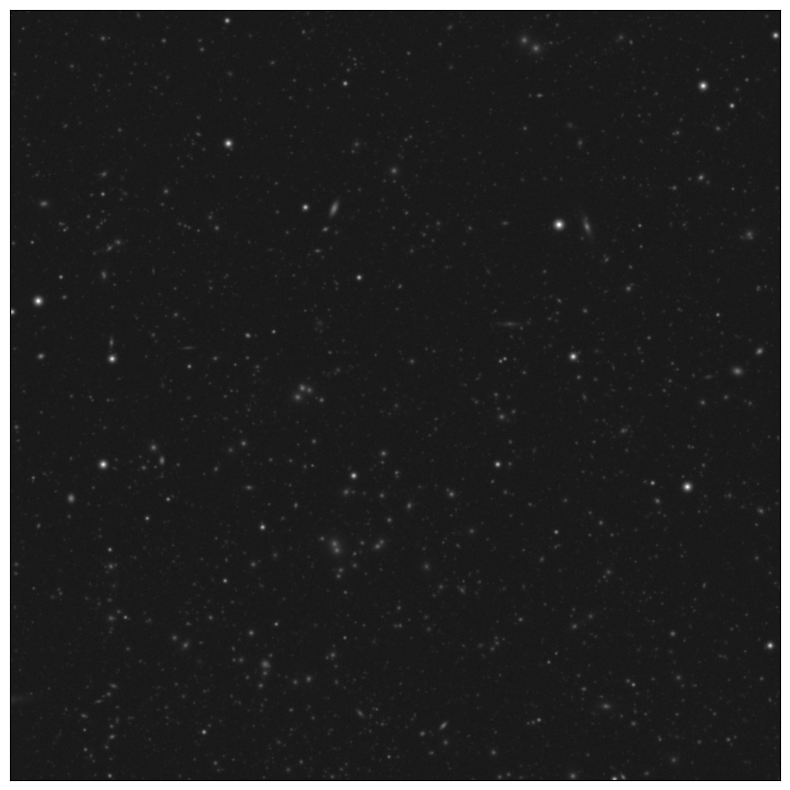

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))
_ = ax.imshow(logimage, cmap = 'gray', origin = 'lower')
_ = ax.set_xticks([])
_ = ax.set_yticks([])

fig.savefig("figures/figure1a.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [6]:
galaxy_plocs = result_dict['other_info']['full_cat']['plocs'].squeeze()
plocs_mask = (galaxy_plocs <= 2048).all(dim=-1)

galaxy_plocs = galaxy_plocs[plocs_mask]
galaxy_shear1 = result_dict['other_info']['full_cat']['shear1'].squeeze()[plocs_mask]
galaxy_shear2 = result_dict['other_info']['full_cat']['shear2'].squeeze()[plocs_mask]
galaxy_convergence = result_dict['other_info']['full_cat']['convergence'].squeeze()[plocs_mask]

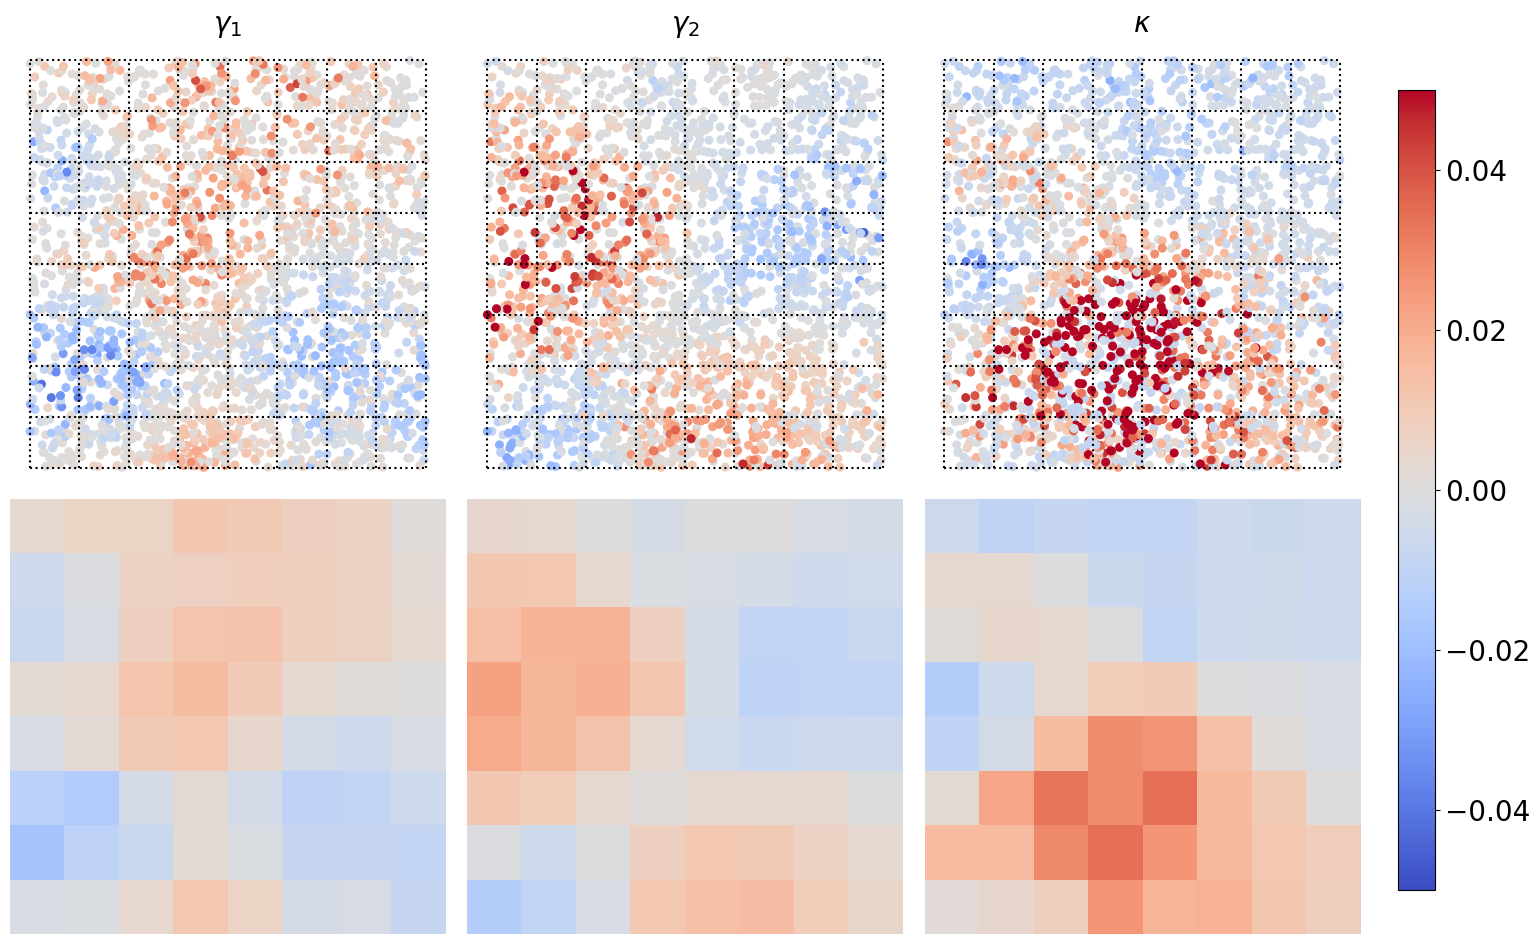

In [7]:
fig, ax = plt.subplots(2, 3, figsize = (15,10))
alpha = 1
s = 30
fontsize = 20
cmap = 'coolwarm'
vmin = -0.05
vmax = 0.05

_ = ax[0,0].scatter(galaxy_plocs[:,1], galaxy_plocs[:,0], c = galaxy_shear1,
                    vmin = vmin, vmax = vmax, alpha = alpha, s = s, cmap = cmap)
_ = ax[0,0].vlines(x = [256 * c for c in range(2048//256 + 1)],
                   ymin = 0, ymax = 2048, color = 'black', linestyle = ':')
_ = ax[0,0].hlines(y = [256 * c for c in range(2048//256 + 1)],
                   xmin = 0, xmax = 2048, color = 'black', linestyle = ':')
_ = ax[0,0].set_title(r'$\gamma_1$', fontsize = fontsize)
_ = ax[0,0].set_xticks([])
_ = ax[0,0].set_yticks([])

_ = ax[0,1].scatter(galaxy_plocs[:,1], galaxy_plocs[:,0], c = galaxy_shear2,
                    vmin = vmin, vmax = vmax, alpha = alpha, s = s, cmap = cmap)
_ = ax[0,1].vlines(x = [256 * c for c in range(2048//256 + 1)],
                   ymin = 0, ymax = 2048, color = 'black', linestyle = ':')
_ = ax[0,1].hlines(y = [256 * c for c in range(2048//256 + 1)],
                   xmin = 0, xmax = 2048, color = 'black', linestyle = ':')
_ = ax[0,1].set_title(r'$\gamma_2$', fontsize = fontsize)
_ = ax[0,1].set_xticks([])
_ = ax[0,1].set_yticks([])

_ = ax[0,2].scatter(galaxy_plocs[:,1], galaxy_plocs[:,0], c = galaxy_convergence,
                    vmin = vmin, vmax = vmax, alpha = alpha, s = s, cmap = cmap)
_ = ax[0,2].vlines(x = [256 * c for c in range(2048//256 + 1)],
                   ymin = 0, ymax = 2048, color = 'black', linestyle = ':')
_ = ax[0,2].hlines(y = [256 * c for c in range(2048//256 + 1)],
                   xmin = 0, xmax = 2048, color = 'black', linestyle = ':')
_ = ax[0,2].set_title(r'$\kappa$', fontsize = fontsize)
_ = ax[0,2].set_xticks([])
_ = ax[0,2].set_yticks([])

_ = ax[1,0].imshow(data_to_cache[0]['tile_catalog']['shear_1'].squeeze(),
                   origin = 'lower', cmap = cmap, vmin = vmin, vmax = vmax)
_ = ax[1,0].set_xticks([])
_ = ax[1,0].set_yticks([])

_ = ax[1,1].imshow(data_to_cache[0]['tile_catalog']['shear_2'].squeeze(),
                   origin = 'lower', cmap = cmap, vmin = vmin, vmax = vmax)
_ = ax[1,1].set_xticks([])
_ = ax[1,1].set_yticks([])

conv = ax[1,2].imshow(data_to_cache[0]['tile_catalog']['convergence'].squeeze(),
                   origin = 'lower', cmap = cmap, vmin = vmin, vmax = vmax)
_ = ax[1,2].set_xticks([])
_ = ax[1,2].set_yticks([])

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.975, 0.1, 0.025, 0.8])
cbar_ax.tick_params(labelsize = fontsize)
fig.colorbar(conv, cax=cbar_ax)

fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.05, hspace=0.01)

for a in ax.flat:
    for spine in a.spines.values():
        spine.set_visible(False)

fig.savefig("figures/figure1b.png", dpi = 300, transparent = True, bbox_inches = 'tight', pad_inches = 0)